# Chapter 3 Convolutional Neural Network

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import BatchSampler
from idlmam import *
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *

import pandas as pd
import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pprint

In this chapter we are going to learn about "convolutional layer", which can act as a replacement to <code> nn.Linear </code>.

## Spatial structural prior belief

Neural network get really useful when we use them to impose some kind of prior belief, specifically structural priors. The most common types of structure encoded into neural networks are spatial correlation (e.g., images in this chapter) and sequential relationship (e.g., weather changes from one day to another).

In our previous problem represented as $(N, D)$ matrix, with $N$ data points and $D$ features, we could have re-arranged the features' order and it would not change the meaning. All that's matter is if column $j$ corresponds to a specific feature is always put in a consistent position. 

While in spatial data, such as picture, the order of the pixels are is important. If it's shuffeled it would change the meaning.

So, if we have $N$ images, each has a height $H$, and a width $W$. As a starting point we might consider a "matrix" of image data to have shape $(N, W, H)$.

This gives us a three dimensional tensor. This would be fine if we had black-and-white images only. But for color we need to add some *channels* to our representation. Every channel has the same width and height, but represents a different perceptual concept.

Color usually represented with a Red, Green, and Blue *channel*, and we interpret the mixture of the three components to create a final color image. 

So , if we want to include that, we need to have an additional dimension to the tensor for the channels $(N, C, W, H)$.

Now, we have a four dimensional tensor, and there is structure to the tensor. By structure we mean that the axes of the tensor, and the order we access data in, has a specific meaning (we cannot shuffle them).

For example, if $x$ was a batch of color images <code> x[3, 2, 0, 0] </code> is saying "from the 4th image ($N=3$) grab the blue value ($C=2$) of the upper left pixel ($0, 0$)". Or we can grab the red, green, and blue value using <code> x[3, :, 0, 0] </code>.

### Loading MNIST with PyTorch

MNIST is a collection of black and white images of the digit 0 through 9. Each has the size of $28 \times 28$ pixels.

In [2]:
import torchvision
from torchvision import transforms

In [3]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True)
x_example, y_example = mnist_data_train[0]
type(x_example)

PIL.Image.Image

Now, since the data returned is in a form of PIL images, we need to transofrm it to PyTorch tensor where the minimum possible value is 0.0, and the maximum is 1.0.

In [4]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True,
transform=transforms.ToTensor())

mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True,
transform=transforms.ToTensor())

x_example, y_example = mnist_data_train[0]
print(x_example.shape)

torch.Size([1, 28, 28])


We now have a data with single example, which has a shape of (1, 28, 28) for $C=1$ (black and white), and a width and height of 28 pixels.

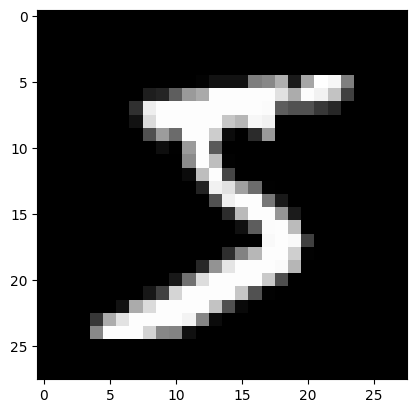

In [5]:
from pylab import *
import matplotlib.pyplot as plt

imshow(x_example[0,:], cmap='gray')
plt.show()

Now, lets try to do color version

In [6]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]], dim=0)
print(x_as_color.shape)

torch.Size([3, 28, 28])


Now, we need to be careful, in PyTorch an image is represented as (N, C, W, H), but in imshow, the parameter expected is (W, H, C). So, we will need to *permute* the dimension. The order of the original data is (C, W, H) => (0, 1, 2). to permute we need (1, 2, 0).

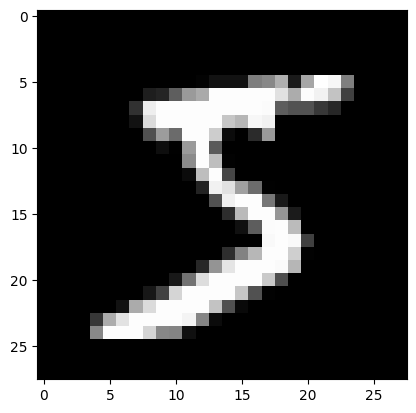

In [7]:
imshow(x_as_color.permute(1,2,0))
plt.show()

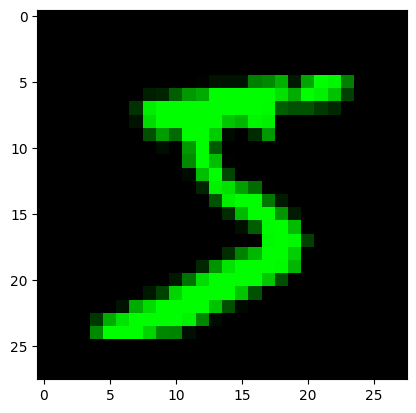

In [8]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]])

# No red
x_as_color[0,:] =0 

# No blue
x_as_color[2,:] =0 

# Leaving the green value

imshow(x_as_color.permute(1,2,0))

plt.show()

Let's mix the three color in different number representation

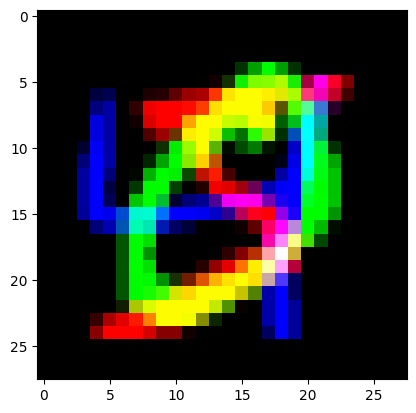

In [9]:
#grab 3 images
x1, x2, x3 = mnist_data_train[0], mnist_data_train[1], mnist_data_train[2]
#drop the labels
x1, x2, x3 = x1[0], x2[0], x3[0]

x_as_color = torch.stack([x1[0,:], x2[0,:], x3[0,:]], dim=0)
imshow(x_as_color.permute(1,2,0))

plt.show()

## What are Convolutions?

There is a *prior* we would like to put into our model (some kind of spatial relationship). The prior that convolutions encode is that **things near each other are related to each other, and far away things have no relationship**.

Think about the pictures of the digit 5 above. Pick any black pixel. Most of its neighboring pixels are also black. Pick any white pixel, most of its neighbors are white or a shade of white. This is a kind of spatial correlation. It doesn’t really matter where in the image this happens, because it tends to happen everywhere by the nature of being an image.

A convolution is a mathematical function with two inputs. It takes image and filter (also known as kernel). The goal is that the filter will be able to
recognize certain patterns from the input, and highlight them in the output.

<img src="https://drive.google.com/uc?export=view&id=1M8VKH1zgvlRqX7aI8zD7r90kdocUPtRP" alt="drawing" width="600"/>

A convolution can be use to impose a spatial prior on any tensor with $r$ dimension.

### 1D Convolutions

Let's assume that we ave a 1D image with a shape of $(C, W)$. For this input, we can define a filter with a shape of $(C, K)$. The value of K depends on us, but the $C$ needs to match up with the $C$ in the input. Since $C$ are always matched we can call the filter as "filter of size $K$".

If we apply a filter with the size of $K$ to an input of shape $(C, W)$, we get an output with a shape of $(C, W-2\cdot [k/2]+1)$.

Look at the example below:

<img src="https://drive.google.com/uc?export=view&id=1MXoqOOAwYEL-H1GVWDHI5WG2FZCWMRI5" alt="drawing" width="600"/>

In code it looks like this:

In [10]:
filter = [1,0, -1]
input = [1,0,2, -1,1,2]
output = []

#Slide the filter over the input
for i in range(len(input)-len(filter)): 
    result =0
    
#apply the filter at this location
for j in range(len(filter)): 
    result += input[i+j]*filter[j]
    output.append(result)
    
#now the output is ready to use

### 2D Convolutions

As we increase the number of dimensions r that our tensor has, the idea of convolutions and how they work stays the same: we will slide a filter around the input, multiplying the values in the filter with each area of the image, and then take the sum. This operation is called convolve represented with $\circledast$ symbol.

<img src="https://drive.google.com/uc?export=view&id=1GTyoIlL6c7tWpmMbcSuhWHu1aCt9E3qU" alt="drawing" width="600"/>


In code it can be written as bellow.

In [11]:
filter = [
    [0,1,0], 
    [0,1,0], 
    [0,1,0]
]

input = [
    [0,0,1,1,0,0],
    [0,1,0,1,0,0],
    [0,0,0,1,0,0],
    [0,0,0,1,0,0],
    [0,0,0,1,1,0],
    [0,1,1,1,1,1]
]

height, width = len(input), len(input[0])
output = []

for i in range(height-len(filter)+1): #Slide the filter over the rows
    row_out = []
    print(i)
    
    # Slide the filter over the columns
    for j in range(width-len(filter)+1):
#         print(j)
        result =0
        
        # Apply the filter at this location
        for k_i in range(len(filter)): 
            for k_j in range(len(filter)):
                result += input[i+k_i][j+k_j]*filter[k_i][k_j]
                
        # Build up a row of the output        
        row_out.append(result) 
    
    # Add the row to the final output
    output.append(row_out) 

#output is ready for use

print(output)

0
1
2
3
[[1, 1, 3, 0], [1, 0, 3, 0], [0, 0, 3, 1], [1, 1, 3, 2]]


### Padding

You will notice that right now, every time we apply a convolution the output becomes skinner and shorter than the original input. That means if we kept applying convolutions over and over again, we would eventually be left with nothing.

The solubtion to this is called padding which can be seen below.

<img src="https://drive.google.com/uc?export=view&id=132JoeoDJBAlBVNKUzh-o0yzpCAPF0b3T" alt="drawing" width="600"/>

This specific example would be called “zero padding by one”, because we added one value to all the edges of the image, and the value was filled with "0". If we  use a convolutional filter of size K, we can use padding of $[K/2]$ to make sure our output stays the same size as our input.

### Weight Sharing

Weight sharing is another way to think about convolutions. Suppose we have a vector (1D array) representing an image and a function $f_\Theta(\cdot)$, which takes an input vector $z$ with $K$ features $z\in {\rm I\!R}^K$. Let's say we have another input with $C=1$ channels and input features $D>K$. We cannot use the same function on $x$ because $D\neq K$.

One way to apply function $f_\Theta(\cdot)$ is to slide the network accross slices of the input. Now if we define our network as <code> f=nn.Linear(K, 1)</code>, this would mean that we implement exactly 1D convolution.

Convolutions are linear operations that work spatially. Like the previous chapter:

    1. Never repeat convolutions, because it is redundant.
    2. We need to include a non-linear activation function after convolutions.

## Utility of Convolutions

To start, let's experiment with the digit 4 from MNIST dataset and scipy <code>convolve</code> function. Note: we can impose an important information by choosing the right kernel.

In [12]:
from scipy.signal import convolve

img_indx =58
img = mnist_data_train[img_indx][0][0,:]
plt.imshow(img, vmin=0, vmax=1, cmap='gray')

Blurring image 

$$ image \circledast \frac{1}{9} 
\left[\begin{array}{cc} 
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\
\end{array}\right]
$$

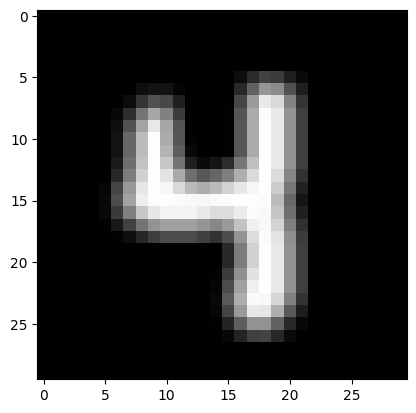

In [13]:
blur_filter = np.asarray([[1,1,1],
[1,1,1],
[1,1,1]
])/9.0
blurry_img = convolve(img, blur_filter)
plt.imshow(blurry_img, vmin=0, vmax=1, cmap='gray')
plt.show()

Edge image 

$$ image \circledast 
\left[\begin{array}{cc} 
-1 & -1 & -1 \\
-1 & 8 & -1 \\
-1 & -1 & -1 \\
\end{array}\right]
$$

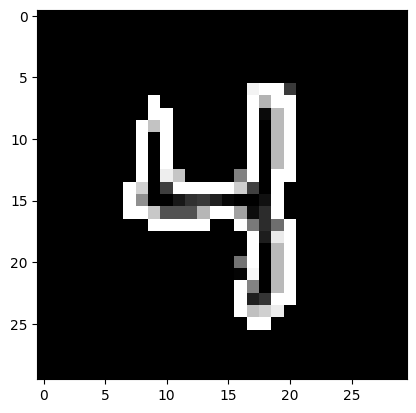

In [14]:
#We can find edges by focusing on the difference between a pixel, and its neighbors
edge_filter = np.asarray([[-1,-1,-1],
[-1,8,-1],
[-1,-1,-1]
])
edge_img = convolve(img, edge_filter)
plt.imshow(edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

Horizontal edge image 

$$ image \circledast 
\left[\begin{array}{cc} 
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1 \\
\end{array}\right]
$$

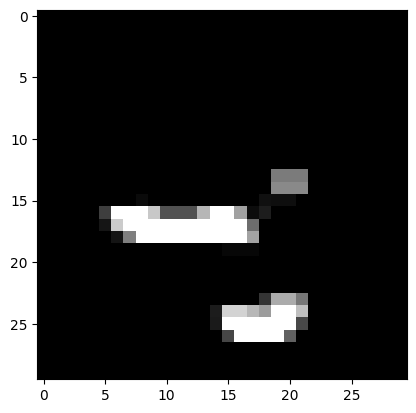

In [15]:
#We could look for only horizontal edges
h_edge_filter = np.asarray([[-1,-1,-1],
[0,0,0],
[1,1,1]
])
h_edge_img = convolve(img, h_edge_filter)
plt.imshow(h_edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

With deep learning, we don’t have to go through all the mental effort of trying to imagine and test all the filters we might need. Instead, we can let the neural network learn the filters itself. That way we save ourselves from a labor intensive process, and the kernels are optimized for the specific problem we care about.

## Building CNN

Let's say we have $I \in {\rm I\!R}^{C, W, H}$ and apply a convolution using a filter $g \in {\rm I\!R}^{C, K, K}$, to get result ${\rm I\!R}^{W', H'}$. This can be written as: $$R = I \circledast g$$, where $R$ is the result, $I$ is the input image and $g$ is the filter.

<img src="https://drive.google.com/uc?export=view&id=1iLi3oT_rX_ulVBd83D0tHNNSWVNmrRrp" alt="drawing" width="600"/>



Because the input has a shape of $(C, W)$, the filter has a shape of $(C, K)$. So when the input has multiple channels, the kernel will have a value for each channel separately. That means for a color image, we could have a filter that looks for “red horizontal lines, blue vertical lines, and no green” all in one operation. But it also means that after applying one filter we get one output.

Considering the examples above, we probably want more than just one filter.

We want to have the channel to have different filters $C_{out}$. First let assume that $C_{in}$ indicates the number of channels in the input. In this case we would then have a tensor that represents all of the filters as $G \in {\rm I\!R}^{C_{out}, C_{in}, K, K}$. This gives us new result $R \in {\rm I\!R}^{K, W', H'}$. The new operation can be written as $R = I \circledast G$.

The picture below shows the overview of the process.

<img src="https://drive.google.com/uc?export=view&id=1jkqtwyUTA8QXO96qDhkvo856rBE4jI_4" alt="drawing" width="600"/>

The same process is used by all three standard convolution sizes.

1. 1D-CNN: (Batch, Channels, Width)
2. 2D-CNN: (Batch, Channels, Width, Height)
3. 3D-CNN: (Batch, Channels, Width, Height, Depth)

The picture below shows all the steps and math for an input image with explicitly $C_{in} = 3$, $C_{out} = 2$, and $K = 3$.

<img src="https://drive.google.com/uc?export=view&id=1lb-xz858NcBeWiTdPcVp3YVwtW_CZn8Q" alt="drawing" width="600"/>

The input image comes in and has $C_{in} = 3$ channels, and we are going to process it using <code>nn.Conv2d(C_in, C_out, 3, padding=3\2)(x) = output</code>. Since $C_{out} = 2$, that means we process the input with two different filters, add the bias terms for every location.

As a result we get two resulting images that have the same height and width as the original image (because we used padding). 

In the final step the results are stacked together into one larger single image with 2 channels because we specified $C_{out} = 2$.

In fully connected neural network, we wrote something like:

```python
nn.Sequential(
    nn.Linear(d, n),
    nn.tanh(),
    nn.Linear(n, classes)
)
```

which in mathematical notation:
$$f(x)=tanh(\underbrace{x^T}_{input} \underbrace{W_{d\times n}^{(h_1)}  + b^{(h_1)}}_{nn.Linear(d, n)})\underbrace{W_{n\times classes}^{(out)}  + b^{(out)}}_{nn.Linear(n, classes)}$$

In convolutions, it will be something like:

```python
nn.Sequential(
    nn.Conv2d(C_in, C_out, K),
    nn.tanh(),
    nn.Flatten(),
    nn.Linear(C_out \cdot w \cdot h, C)
)
```

which in mathematical notation:
$$f(x)=tanh\left(
\underbrace{x^{C_{in}, W, H}}_{input} \circledast
\underbrace{W_{C_{out}, C_{in}, K, K}^{(h_1)}  + b^{(h_1)}}_{nn.Conv2d(C_{in}, C_{out}, K)}\right)
\underbrace{W_{(C_{out}\cdot w \cdot h), C}^{(out)}  + b^{(out)}}_{nn.Linear(C_{out} \cdot w \cdot h, C)}$$

When simplified:
$$f(x)=tanh\left(x\circledast W_{(h_1)}+B_{(h_1)}\right) W_{(out)} + b_{(out)}$$

In the convolutions case, we need flatteing because the output of the convolutions is $(C, W, H)$ while the linear function expects something like $(C \times W \times H)$, which is a one dimension.

Now, since we have learned the structure let's build our model.

In [16]:
# Check and decide device to be used
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Batch size
B =32

# Train and eval data
mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)

Now, since we are training in a batch size, the initial shape will be $(B, C, W, H)$, where $B=32$ and $C=1$.

We will start by building the linear model and the convolution model (for the sake of comparison).

In [17]:
# Input image of 28*28
W = 28
H = 28
D = W*H

# Number of channel(s)
C =1

# Classes of predictions
classes =10

# Number of filters to be used
filters =16

# Filter size
K =3

# Linear model
model_linear = nn.Sequential(
    nn.Flatten(), #(B, C, W, H) -> (B, C*W*H) = (B,D)
    nn.Linear(D,256),
    nn.Tanh(),
    nn.Linear(256, classes),
)

# CNN model
model_cnn = nn.Sequential(
    #Conv2d follows the pattern of:
    #Conv2d(# of input channels, #filters/output-channels, #filter-size)
    nn.Conv2d(C, filters, K, padding=int(K/2)), #$x\circledast G$
    nn.Tanh(),#Activation functions work on any size tensor
    nn.Flatten(), #Convert from (B, C, W, H) ->(B, D). This way we can use a Linear layer after
    nn.Linear(filters*D, classes),
)

In [18]:
loss_func = nn.CrossEntropyLoss()

cnn_results = train_simple_network(
    model_cnn, 
    loss_func, 
    mnist_train_loader,
    test_loader=mnist_test_loader, 
    score_funcs={'Accuracy': accuracy_score}, 
    device=device,
    epochs=10)

fc_results = train_simple_network(
    model_linear, 
    loss_func, 
    mnist_train_loader,
    test_loader=mnist_test_loader, 
    score_funcs={'Accuracy': accuracy_score}, 
    device=device,
    epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

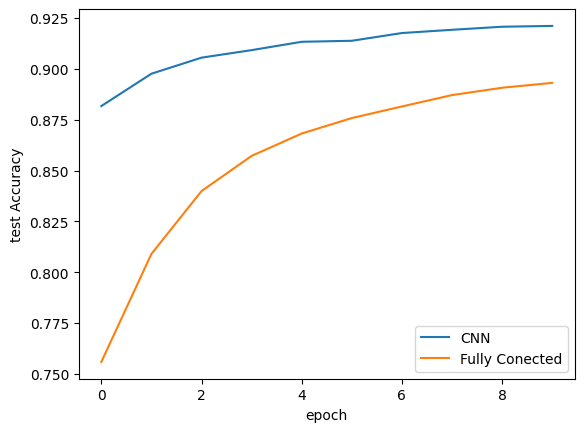

In [19]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_results, label='Fully Conected')
plt.show()

From the graph, we can see that the CNN works better than the fully connected neural network. However, it does not mean that it will always outperform the fully connceted neural network. But from here we know that CNN will perform better when we have prior structure.

## Pooling and object location.

Just like the linear neural network, we can make our CNN more powerful by adding more layers with non-linearity in between. Before we do that, there is one special type of layer that is usually used in CNNs called *pooling layer*.

The problem with the previous sturcture is that first, we use the convolution layer to learn about the image spatial information. However, eventually we switch to fully connected layer, which does not understand the spatial nature of the data. For this reason, the nn.Linear layer will learn to look for values at very specific location.

The previous structure is okay with the MNIST data because all digits are aligned. However, that might not be the case in real life scenario. Hence, we are introduced with pooling. Let's see the sample below.

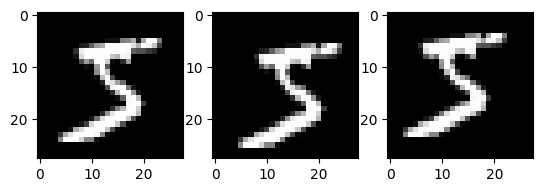

In [55]:
# Moving image slightly

img_indx =0
img, correct_class = mnist_data_train[img_indx]
img = img[0,:]

#move to the lower right, then upper left
img_lr = np.roll(np.roll(img,1, axis=1),1, axis=0)
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0)
#plot the images
f, axarr = plt.subplots(1,3)
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(img_lr, cmap='gray')
axarr[2].imshow(img_ul, cmap='gray')
plt.show()

Let's quickly put these images to be predicted.

This is a simple way to apply a model to single images at a time.

In [59]:
# Eval mode since we are not training
model = model_cnn.cpu().eval()

# Input Image
img_indx =0
img, correct_class = mnist_data_train[img_indx]

img = img[0,:]
img_lr = np.roll(np.roll(img,1, axis=1),1, axis=0)
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0)


def pred(model, img):
    
    # Always turn of grad when evaluating
    with torch.no_grad():
        w, h = img.shape
        
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img)
            
        # Re-shape it as (B, C, W, H)
        x = img.reshape(1,-1,w,h)

        # Get the logits
        logits = model(x) 

        # remember that the CrossEntropy loss we used handles softmax implicitly. So when we use a
        # model trained with CrossEntropy, we need to call F.softmax ourselves to transform the outputs
        # into probabilities.
        y_hat = F.softmax(logits, dim=1)

        # Convert prediction to numpy array.
        return y_hat.numpy().flatten()

print(pred(model, img))

[2.6710976e-03 2.8192467e-04 6.0514626e-03 2.7200451e-01 1.8148492e-05
 7.0706850e-01 6.8056397e-04 5.8715269e-03 3.5915244e-03 1.7607242e-03]


In [60]:
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)
print("Org Img Class {} Prob: ".format(correct_class) , img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob: ".format(correct_class) , img_ul_pred[correct_class])

Org Img Class 5 Prob:  0.7070685
Lower Right Img Class 5 Prob:  0.43311232
Uper Left Img Class 5 Prob:  0.1857683


As can be seen the probability score is low when the image shifts.
We can obtain some partial translation invariance with an operation known as pooling.

Below is simple process of max pooling.

<img src="https://drive.google.com/uc?export=view&id=16e-Q5ulz3AdhHZSN6IoiCve6oIrKS40X" alt="drawing" width="600"/>

It's simply just taking the max value within the kernel size $K$.
The choice of how many pixels to "slide" is called *stride*. By default we use $stride = 1$. We use $stride=K$ so that th einput is shrunk by a factor of $K$ as shown on the image above.

The intuition behind pooling is that it gives us more robustness to slight changes in values. Consider the first image above, if your shifted every value over to the right by one position. Five of the nice output values would not change, giving it a minor degree of invariance to translating the image by one pixel. This is not perfect, but it helps reduce the impact of such alterations. If we accumulate this effect through multiple rounds of pooling, we can make the effect stronger.

For 2D MaxPool, when $stride = K$, if our input had the shape of $(B, C, W, H)$, the output of <code> nn.MaxPool2d(K) </code> will be a shape of $(B, C, W/K, H/K)$. Since C remains the same, that means we apply this operation to every channel independently.

### CNNs with Max Pooling

So how many max pooling should we use and where exactly should we use it?
let's say that everytime that we do max pooling, we shrink our size by a factor of $K$. That means $n$ rounds of pooling means a shrinking by a factor or $K^n$.

Our problem is a $28 \times 28$ problem, hence, we can only apply 4 rounds of pooling maximum assuming that $K=2$. Because 5 rounds will give us $\frac{28}{2^5}$ which is less than a pixel output.

However, does applying 4 pooling make sense? Outputing 1.75 pixel, our model probably would not be able to guess the digit. This includes us as well. So, in this scenario 2 or 3 pooling will still make sense.

In [63]:
model_cnn_pool = nn.Sequential(
    nn.Conv2d(C, filters,3, padding=int(3/2)),
    nn.Tanh(),
    nn.Conv2d(filters, filters,3, padding=int(3/2)),
    nn.Tanh(),
    nn.Conv2d(filters, filters,3, padding=int(3/2)),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(filters,2*filters,3, padding=int(3/2)),
    nn.Tanh(),
    nn.Conv2d(2*filters,2*filters,3, padding=int(3/2)),
    nn.Tanh(),
    nn.Conv2d(2*filters,2*filters,3, padding=int(3/2)),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    # Why did we reduce the number of units into the Linear layer by a factor of 4^2? Because
    # pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did
    # this two times.
    nn.Linear(int(2*filters*D/(4**2)), classes),
)
cnn_results_with_pool = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader,
test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

In [65]:
model = model_cnn_pool.cpu().eval()

img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob: ".format(correct_class) , img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob: ".format(correct_class) , img_ul_pred[correct_class])

Org Img Class 5 Prob:  0.5531059
Lower Right Img Class 5 Prob:  0.7203776
Uper Left Img Class 5 Prob:  0.40441492


From the results above, we can see a slight improvement from the model.

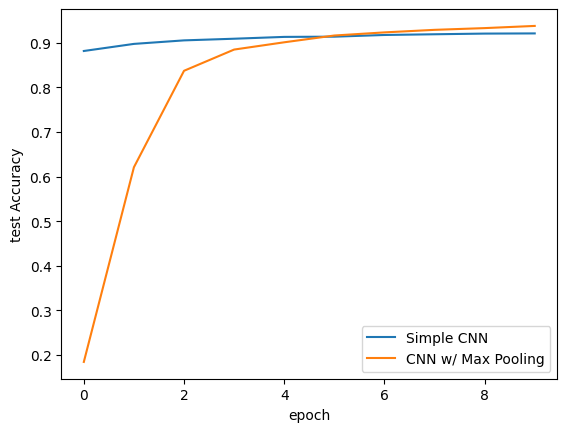

In [67]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='Simple CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')
plt.show()

More advance technique for CNN can be found in MEAP book page 96-100 about Data Augmentation